# Capstone: Web Traffic Time Series Forecasting

![web](images/map_webtraffic.png)

reference: [Kaggle Challenge 2017](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data)

- Web traffic can be defined as the number of visits to a website, including requests sent and received by web users. We aim to predict future web traffic for approximately a total of 145k Wikipedia articles to make better traffic control decisions. The increase in traffic for the websites could cause a lot of inconvenience for the users by a crashed site or very slow loading time. Therefore, a traffic management technique or plan should be put in place to reduce the risk of such problems.

# Import packages and define functions

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # to show Japanese & Chinese character
import re
import seaborn as sns
import datetime 
from collections import Counter

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Data Collection and Wrangling

In [3]:
datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored
figdir = '../output/figures'

## Datasets consist of train and key:
- **train.csv**
    - 145k rows each of which represent a different Wikipedia page
    - 804 columns: article + daily traffic on that particular Wikipedia page (803 days: 2015-07-01 to 2017-09-10)
    - The first column contains the name of the page which includes 
        - the language of the page (e.g., English en, Spanish es, Chinese zh)
        - type of access (e.g., desktop, all access)
        - agent (e.g., spider, actual traffic)
- **key.csv**
    - the mapping between the page names and the shortened Id column used for prediction
    - 2 columns: page name (consistent to the page name in train.csv) and id

In [3]:
''' Read the training dataset '''
train = pd.read_csv(os.path.join(datadir, 'train_2.csv.zip'))
key   = pd.read_csv(os.path.join(datadir, 'key_2.csv.zip'))

In [4]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [5]:
key.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [7]:
key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Page    object
 1   Id      object
dtypes: object(2)
memory usage: 137.2+ MB


In [8]:
''' check the missing values '''
train.isnull().sum()
#train.isnull().values.any()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2017-09-06     1775
2017-09-07     3467
2017-09-08     1061
2017-09-09     3332
2017-09-10     5578
Length: 804, dtype: int64

## Handling Missing values

- There are two kinds of missing in this time series dataset
    1. the data is actually missing --> interpolation 
    2. the page is not created yet --> fill with zero

In [9]:
# omit the page titles
Page_title = train.Page   # keep the page column to revive it after handling the missing data
train_nopage = train.drop(columns=['Page'])

In [10]:
train_nopage.isnull().sum()

2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
2015-07-05    20659
              ...  
2017-09-06     1775
2017-09-07     3467
2017-09-08     1061
2017-09-09     3332
2017-09-10     5578
Length: 803, dtype: int64

In [11]:
# convert the format of column names from string to datetime
train_nopage.columns = pd.to_datetime(train_nopage.columns)

In [12]:
# First situation: the data is actually missing
# interpolation
train_imputed = train_nopage.interpolate(method='linear', axis=1).copy()

In [13]:
train_imputed.isnull().sum()

2015-07-01    20740
2015-07-02    19767
2015-07-03    19256
2015-07-04    18983
2015-07-05    18818
              ...  
2017-09-06        0
2017-09-07        0
2017-09-08        0
2017-09-09        0
2017-09-10        0
Length: 803, dtype: int64

In [14]:
# Second situation: the page is not created yet
# fill with zero
train_imputed.fillna(0, inplace=True)

In [15]:
train_imputed.isnull().sum()

2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
2015-07-05    0
             ..
2017-09-06    0
2017-09-07    0
2017-09-08    0
2017-09-09    0
2017-09-10    0
Length: 803, dtype: int64

In [84]:
train_imputed.iloc[4].Page

'52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider'

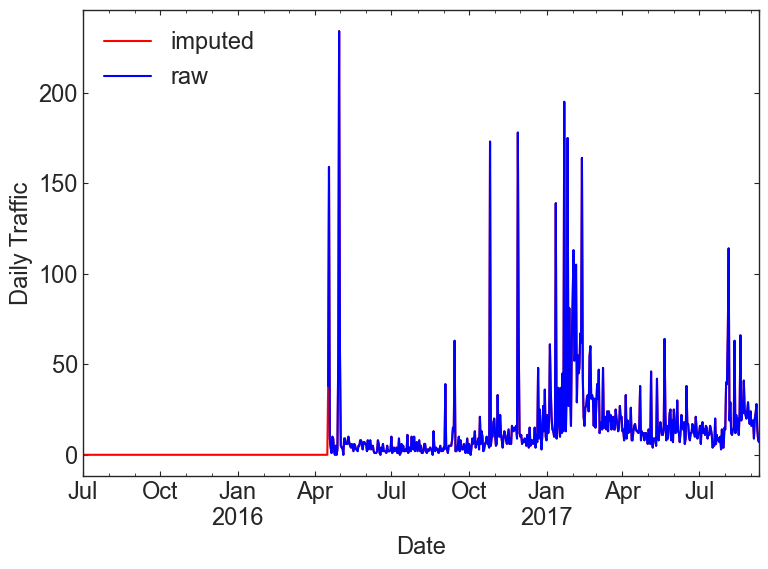

In [18]:
# visualize the imputed dataset
fig, ax = plt.subplots()

n_obs = 4  # location of the page

train_imputed.iloc[n_obs].T.plot(color='red', label='imputed', ax=ax)  # imputed dataset
train_nopage.iloc[n_obs].T.plot(color='blue', label='raw', ax=ax)  # raw dataset

#ax.set_xlim('2015','2017')
ax.set(xlabel='Date', ylabel='Daily Traffic')
ax.legend(loc='upper left', frameon=False)

fig.tight_layout()
fig.savefig(os.path.join(figdir,'imputed_data.png'));

In [19]:
train_imputed.insert(loc=0, column='Page', value=Page_title)

In [20]:
train_imputed.head()

,Page,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,...,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [21]:
print(train_imputed.shape)

(145063, 804)


## save the imputed dataset

In [20]:
train_imputed.to_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'), index=False, compression='zip')

# Exploratory Data Analysis

In [4]:
''' Read the training dataset '''
train_imputed = pd.read_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'))

## Grouping by languages

In [22]:
''' function for finding language from given page title '''
def get_language(page):
    lang = re.search('[a-z][a-z].wikipedia', page)
    if lang:
        return lang[0][0:2]
    elif '.wikimedia' in page:
        return 'wikimedia'
    elif '.mediawiki' in page:
        return 'mediawiki'
    else:
        return 'NA'

In [23]:
train_imputed['Language'] = train_imputed.Page.map(get_language)

In [24]:
train_imputed[['Page','Language']].sample(10)

,Page,Language
50535,Arsène_Wenger_de.wikipedia.org_all-access_spider,de
101254,Мир_Дикого_запада_(телесериал)_ru.wikipedia.or...,ru
97955,Нью-Йорк_ru.wikipedia.org_all-access_all-agents,ru
121590,フラッシュモブ_ja.wikipedia.org_all-access_all-agents,ja
67503,Fifty_Shades_of_Grey_(Film)_de.wikipedia.org_d...,de
98452,Битва_за_Москву_ru.wikipedia.org_all-access_al...,ru
13420,Category:Close-ups_of_human_vaginas_commons.wi...,wikimedia
111248,Hotel_LaFontaine_en.wikipedia.org_all-access_a...,en
112779,Rally_of_Brazil_en.wikipedia.org_all-access_al...,en
132778,古畑任三郎_ja.wikipedia.org_all-access_spider,ja


In [25]:
print(Counter(train_imputed.Language))

Counter({'en': 24111, 'ja': 20431, 'de': 18547, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069, 'wikimedia': 10552, 'mediawiki': 7300})


In [26]:
train_imputed.Language.unique()

array(['zh', 'fr', 'en', 'wikimedia', 'ru', 'mediawiki', 'de', 'ja', 'es'],
      dtype=object)

In [27]:
def convert_full_language(lang):
    lang_label = {'zh':'Chinese', 'fr':'French', 'en':'English', \
                  'ru':'Russian', 'de':'German', 'ja':'Japanese', \
                  'es':'Spanish', 'wikimedia':'wikimedia', 'mediawiki':'mediawiki'}
    return lang_label[lang]

train_imputed['Language'] = train_imputed.Language.map(convert_full_language)

### Number of Articles per language

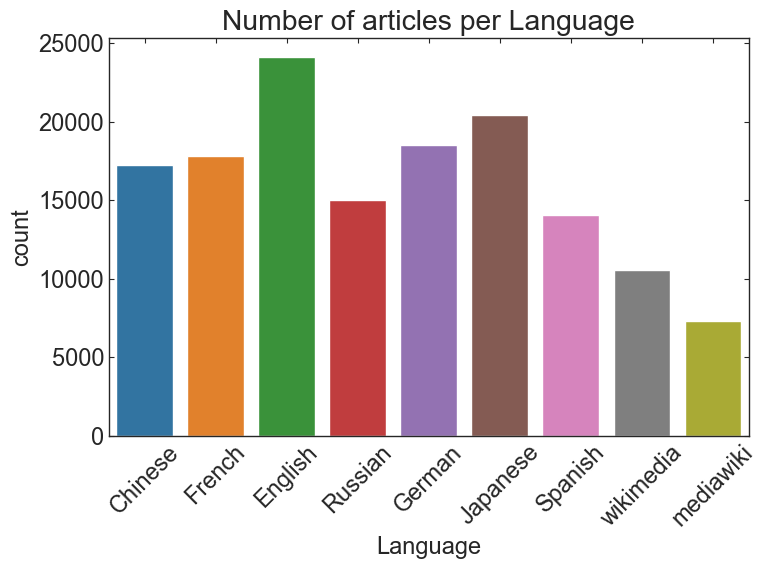

In [30]:
x_order = ['Chinese','French','English','Russian','German','Japanese','Spanish','wikimedia','mediawiki']

fig, ax = plt.subplots()
sns.countplot(data=train_imputed, x='Language', order=x_order, ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of articles per Language')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'n_articles_language.png'));

> English Wikipedia has the largest pages.

### Number of Articles per agents

In [31]:
''' function for finding agents from given page title '''
def get_agent(page):
    if 'spider' in page:
        return 'spider'
    elif 'all-agents' in page:
        return 'all-agents'
    else:
        return 'NA'

In [32]:
train_imputed['Agent'] = train_imputed.Page.map(get_agent)

In [33]:
train_imputed[['Page','Agent']].sample(10)

,Page,Agent
31985,神隱任務：永不回頭_zh.wikipedia.org_all-access_all-agents,all-agents
70190,Juno_(sonda_espacial)_es.wikipedia.org_desktop...,all-agents
50257,The_Lucky_One_–_Für_immer_der_Deine_de.wikiped...,spider
113569,Toyosu_Station_en.wikipedia.org_all-access_all...,all-agents
143838,Anexo:Voleibol_en_los_Juegos_Olímpicos_de_Río_...,spider
89263,永島優美_ja.wikipedia.org_desktop_all-agents,all-agents
31771,2012年班加西攻擊事件_zh.wikipedia.org_all-access_all-a...,all-agents
75715,Justin_Gatlin_en.wikipedia.org_mobile-web_all-...,all-agents
27324,Malcolm_(série_télévisée)_fr.wikipedia.org_all...,all-agents
123003,酉の市_ja.wikipedia.org_all-access_all-agents,all-agents


In [34]:
print(Counter(train_imputed.Agent))

Counter({'all-agents': 110150, 'spider': 34913})


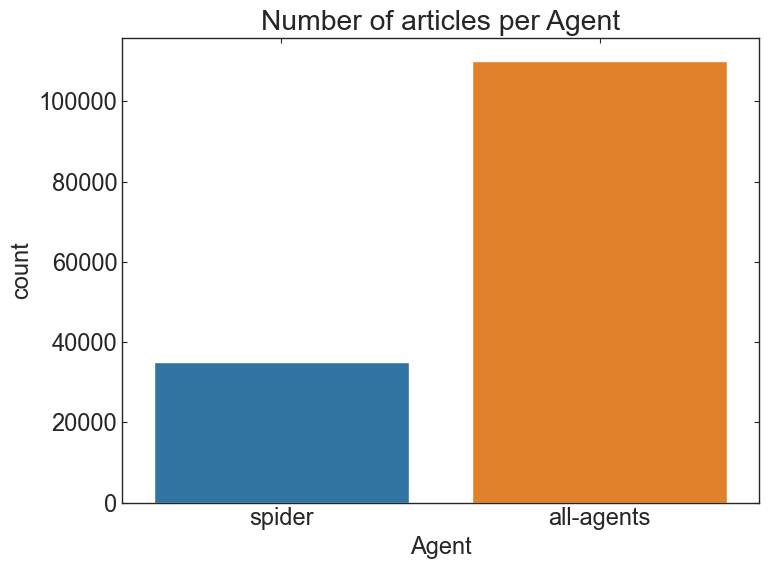

In [40]:
fig, ax = plt.subplots()

sns.countplot(data=train_imputed, x='Agent', ax=ax)
ax.set_title('Number of articles per Agent')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'n_articles_agent.png'));

### Number of Articles per access

In [41]:
''' function for finding access from given page title '''
def get_access(page):
    if 'desktop' in page:
        return 'desktop'
    elif 'mobile-web' in page:
        return 'mobile-web'
    elif 'all-access' in page:
        return 'all-access'
    else:
        return 'NA'

In [42]:
train_imputed['Access'] = train_imputed.Page.map(get_access)

In [43]:
train_imputed[['Page','Access']].sample(10)

,Page,Access
40626,Sage_Stallone_en.wikipedia.org_all-access_all-...,all-access
45668,File:Target_logo.svg_commons.wikimedia.org_all...,all-access
132664,名胡桃城_ja.wikipedia.org_all-access_spider,all-access
43504,Mobile_design_www.mediawiki.org_desktop_all-ag...,desktop
122911,アントニオ猪木対モハメド・アリ_ja.wikipedia.org_all-access_al...,all-access
127041,Праздник_середины_осени_ru.wikipedia.org_all-a...,all-access
131768,Tableau_périodique_des_éléments_fr.wikipedia.o...,all-access
44207,Category:Sex_positions_commons.wikimedia.org_a...,all-access
89228,志田未来_ja.wikipedia.org_desktop_all-agents,desktop
129508,Vitesse_du_son_fr.wikipedia.org_all-access_spider,all-access


In [44]:
print(Counter(train_imputed.Access))

Counter({'all-access': 74315, 'mobile-web': 35939, 'desktop': 34809})


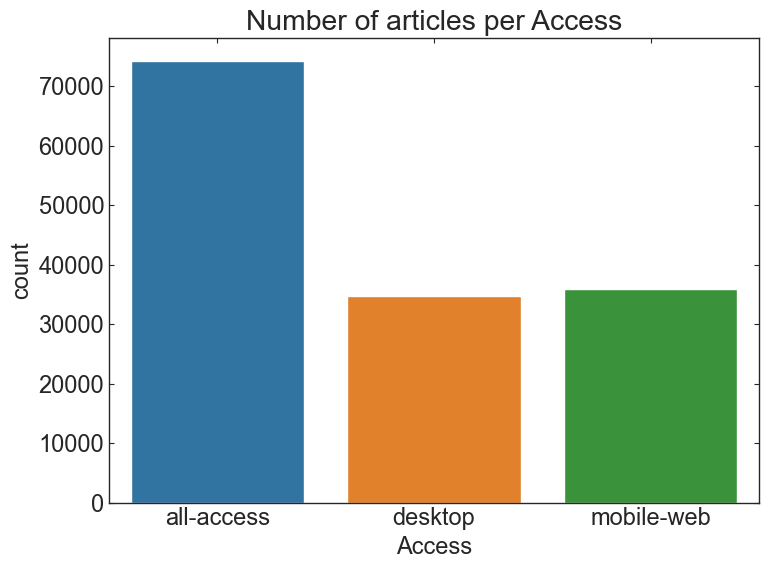

In [45]:
fig, ax = plt.subplots()

sns.countplot(data=train_imputed, x='Access', ax=ax)
ax.set_title('Number of articles per Access')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'n_articles_access.png'));

> The number of articles from Mobile-web access is slightly larger than that from desktop access.

## save the imputed dataset with added features which were extracted from the meta data

In [117]:
# override the previous file
train_imputed.to_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'), index=False, compression='zip')

### Daily traffic for articles in the different languages

In [46]:
''' eliminate mediawiki and wikimedia to see only Wikipedia pages '''
train_wo_NA = train_imputed.loc[(train_imputed.Language != 'mediawiki') & (train_imputed.Language != 'wikimedia')]

In [47]:
languages = train_wo_NA.Language.unique()
print(languages)

['Chinese' 'French' 'English' 'Russian' 'German' 'Japanese' 'Spanish']


In [48]:
''' generate daily traffic information on each language '''
lang_traffic = {}

for lang in languages:
    lang_traffic[lang] = train_imputed.loc[train_imputed.Language == lang].drop(columns=['Page','Language','Agent','Access']).sum(axis=0)

In [49]:
''' convert into dataframe '''
df_lang_traffic = pd.DataFrame(lang_traffic)

In [50]:
df_lang_traffic.T

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Chinese,4144988.0,4.151692e+06,4.123910e+06,4.163694e+06,4.441489e+06,4.464567e+06,4.459718e+06,4.576112e+06,4.548169e+06,4.728224e+06,...,4.769573e+06,5.226684e+06,5.512358e+06,5.075714e+06,5.124686e+06,5.000526e+06,5.212388e+06,5026137.0,5251234.0,5466627.0
French,8458638.0,8.512987e+06,8.186089e+06,8.749959e+06,8.590587e+06,8.949916e+06,8.651196e+06,8.492320e+06,8.403705e+06,7.930772e+06,...,8.905846e+06,8.498777e+06,9.048521e+06,8.177243e+06,7.986859e+06,9.226393e+06,9.071040e+06,8008422.0,8448785.0,9115857.0
English,84712190.0,8.443924e+07,8.016843e+07,8.346406e+07,8.619962e+07,9.281031e+07,8.783948e+07,8.288130e+07,8.480002e+07,8.432071e+07,...,7.844837e+07,8.367547e+07,9.868326e+07,9.967289e+07,9.324506e+07,9.310337e+07,9.794220e+07,74657049.0,72158912.5,82675404.0
Russian,9463854.0,9.627679e+06,8.923491e+06,8.393279e+06,8.938585e+06,9.629063e+06,9.408504e+06,9.364151e+06,9.592358e+06,1.098494e+07,...,9.709236e+06,9.632897e+06,9.969264e+06,9.605905e+06,1.164126e+07,1.513207e+07,1.062166e+07,9195616.0,9359213.0,10230383.0
German,13260519.0,1.308010e+07,1.255416e+07,1.152051e+07,1.339245e+07,1.474183e+07,1.429637e+07,1.450530e+07,1.396485e+07,1.301458e+07,...,1.335494e+07,1.123953e+07,1.229653e+07,1.247074e+07,1.213795e+07,1.237345e+07,1.425800e+07,11705704.5,10902566.5,12183790.0
Japanese,11863200.0,1.362082e+07,1.230543e+07,1.545635e+07,1.482743e+07,1.292083e+07,1.256921e+07,1.249331e+07,1.217882e+07,1.265359e+07,...,1.319893e+07,1.274817e+07,1.328627e+07,1.192526e+07,1.149007e+07,1.183533e+07,1.310296e+07,11830530.0,12637410.0,14077676.0
Spanish,15278553.0,1.460121e+07,1.342790e+07,1.260681e+07,1.371046e+07,1.562568e+07,1.523094e+07,1.478218e+07,1.450318e+07,1.318474e+07,...,1.416267e+07,1.157611e+07,1.422620e+07,1.704043e+07,1.804609e+07,1.741019e+07,1.678652e+07,14396144.0,11635459.0,13516893.0


In [51]:
df_lang_traffic.index = pd.to_datetime(df_lang_traffic.index)

In [52]:
df_lang_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   803 non-null    float64
 1   French    803 non-null    float64
 2   English   803 non-null    float64
 3   Russian   803 non-null    float64
 4   German    803 non-null    float64
 5   Japanese  803 non-null    float64
 6   Spanish   803 non-null    float64
dtypes: float64(7)
memory usage: 50.2 KB


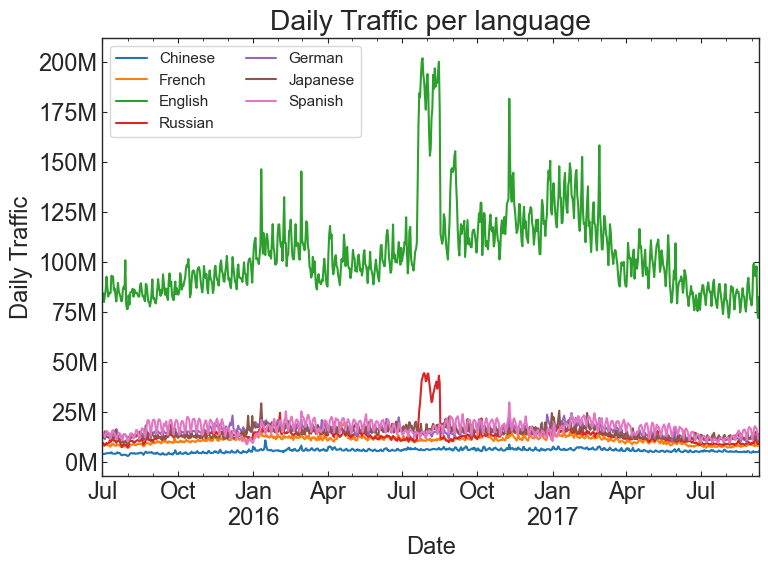

In [53]:
# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

fig, ax = plt.subplots()
#sns.lineplot(data=df_lang_traffic, dashes=False, ax=ax)
#sns.lineplot(data=df_lang_traffic.rolling(30).sum(), dashes=False, ax=ax)
df_lang_traffic.plot(ax=ax)
#df_lang_traffic.rolling(7).sum().plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.legend(loc='best', fontsize=11, ncol=2)
ax.set_title('Daily Traffic per language')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'Daily_Traffic_language.png'));

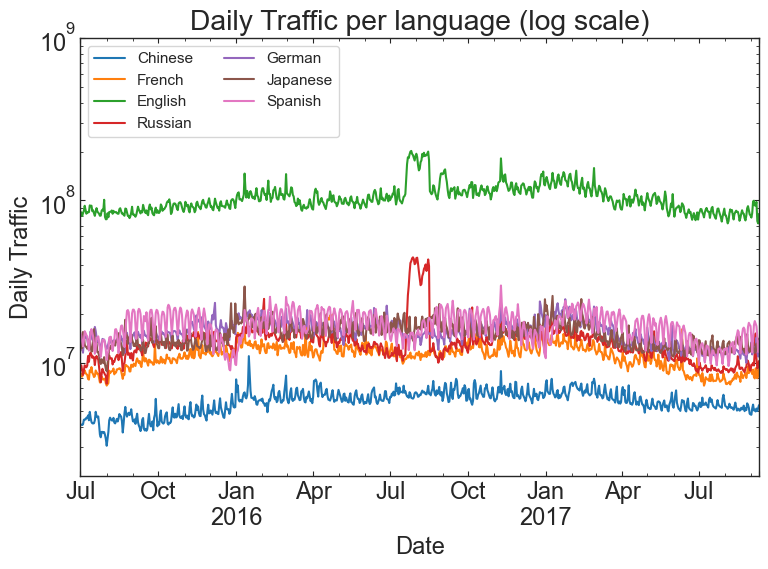

In [54]:
fig, ax = plt.subplots()

df_lang_traffic.plot(ax=ax)
ax.legend(loc='upper left', fontsize=11, ncol=2)
ax.set_title('Daily Traffic per language (log scale)')
ax.set_yscale('log')
ax.set_ylim(2e6,1e9)
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'Daily_Traffic_language_log.png'));

> There is difference in traffic based on language of the data.
> - English wikipedia has the largest daily traffic of all languages.
> - Interestingly, the traffic of Russian wikipedia has the same pattern as that of English pages.

### Daily traffic for articles in the different Access

In [55]:
accesses = train_imputed.Access.unique()
print(accesses)

['all-access' 'desktop' 'mobile-web']


In [56]:
''' generate daily traffic information on each access '''
access_traffic = {}

for access in accesses:
    access_traffic[access] = train_imputed.loc[train_imputed.Access == access].drop(columns=['Page','Language','Agent','Access']).sum(axis=0)

In [57]:
''' convert into dataframe '''
df_access_traffic = pd.DataFrame(access_traffic)

In [58]:
df_access_traffic.T

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
all-access,74698113.0,7.560885e+07,7.108841e+07,7.348648e+07,7.651705e+07,8.088921e+07,7.752718e+07,7.503832e+07,7.541385e+07,7.476574e+07,...,7.594875e+07,7.476695e+07,8.618983e+07,8.618833e+07,8.363202e+07,9.110234e+07,9.672276e+07,69668164.5,67392777.0,75261740.0
desktop,39876738.0,4.016731e+07,3.587656e+07,3.360103e+07,3.542363e+07,4.342738e+07,4.190522e+07,3.966704e+07,4.013629e+07,3.937523e+07,...,4.003201e+07,3.667187e+07,4.208504e+07,4.629471e+07,4.624510e+07,5.006798e+07,5.326176e+07,36531141.0,31207801.5,35866834.0
mobile-web,34097625.0,3.382031e+07,3.420146e+07,3.852830e+07,3.955760e+07,3.642862e+07,3.472064e+07,3.416062e+07,3.398690e+07,3.423915e+07,...,3.133171e+07,3.407214e+07,3.841781e+07,3.493755e+07,3.294186e+07,3.181149e+07,3.137677e+07,31181596.5,34387893.5,38443380.0


In [59]:
df_access_traffic.index = pd.to_datetime(df_access_traffic.index)

In [60]:
df_access_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   all-access  803 non-null    float64
 1   desktop     803 non-null    float64
 2   mobile-web  803 non-null    float64
dtypes: float64(3)
memory usage: 25.1 KB


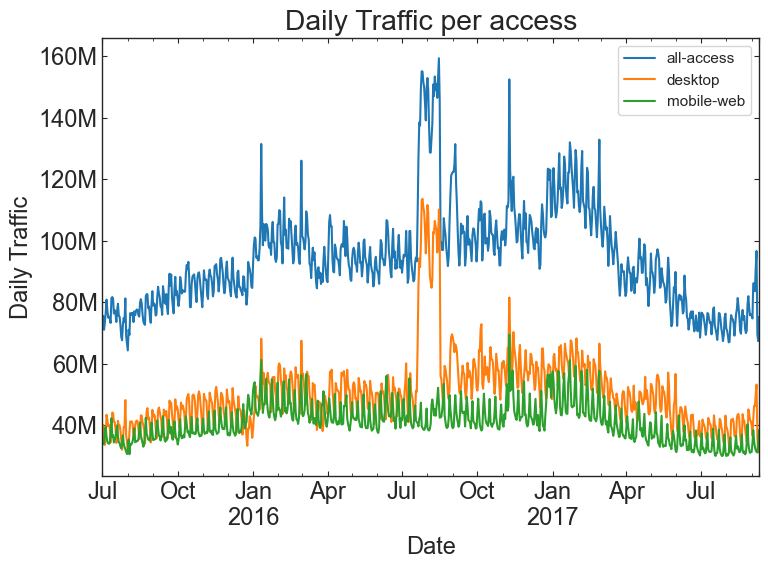

In [61]:
fig, ax = plt.subplots()

# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

df_access_traffic.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.legend(loc='best', fontsize=11)
ax.set_title('Daily Traffic per access')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
fig.savefig(os.path.join(figdir,'Daily_Traffic_access.png'));

> - Overall, the pattern of the daily traffic is similar between desktop access and mobile-web access.
> - The traffic from desktop access is slightly larger than that from mobile-web. It is interesting because the number of articles is slightly larger for the mobile-web access. 
> - There is a spike for the daily traffic from desktop access on August, 2016. This spike is not shown in mobile-web access.

## Daily view on Popular pages 

### Top 5 pages published in English

In [5]:
# extract the data for the English pages
pages_en = train_imputed.loc[train_imputed.Language=='English']
pages_title = pages_en.Page
pages_en = pages_en.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_en.columns = pd.to_datetime(pages_en.columns)

# compute the mean view
pages_en['mean_view'] = pages_en.mean(axis=1)

pages_en = pd.concat([pages_title, pages_en], axis=1)

# find the top 5 popular pages
pages_en_top5 = pages_en.sort_values(by='mean_view', ascending=False)[0:5]

pages_en_top5.set_index('Page', inplace=True)
pages_en_top5['mean_view']

Page
Main_Page_en.wikipedia.org_all-access_all-agents         2.141502e+07
Main_Page_en.wikipedia.org_desktop_all-agents            1.609010e+07
Main_Page_en.wikipedia.org_mobile-web_all-agents         4.780634e+06
Special:Search_en.wikipedia.org_all-access_all-agents    2.366707e+06
Special:Search_en.wikipedia.org_desktop_all-agents       1.747446e+06
Name: mean_view, dtype: float64

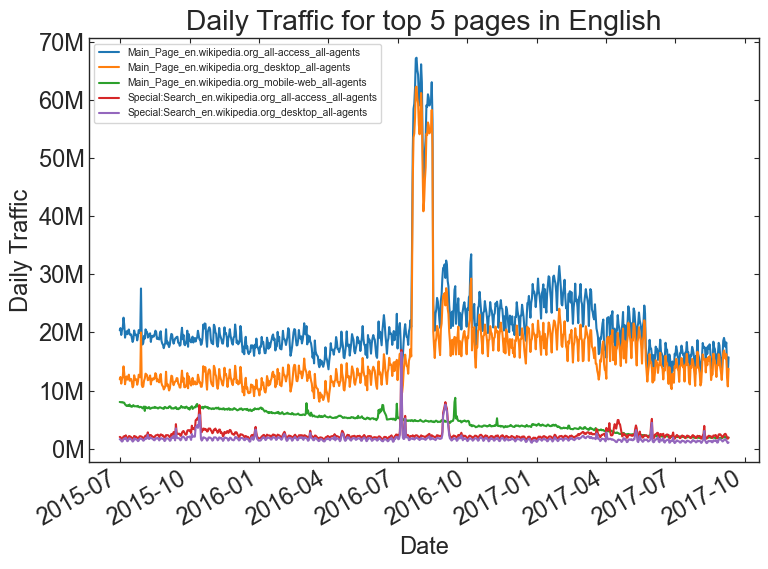

In [6]:
fig, ax = plt.subplots()

# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

pages_en_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.legend(loc='upper left', fontsize=7.4)
ax.set_title('Daily Traffic for top 5 pages in English')
ax.set(xlabel='Date', ylabel='Daily Traffic') 

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_en.png'));

### Top 5 pages published in French

In [7]:
# extract the data for the French pages
pages_fr = train_imputed.loc[train_imputed.Language=='French']
pages_title = pages_fr.Page
pages_fr = pages_fr.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_fr.columns = pd.to_datetime(pages_fr.columns)

# compute the mean view
pages_fr['mean_view'] = pages_fr.mean(axis=1)

pages_fr = pd.concat([pages_title, pages_fr], axis=1)

# find the top 5 popular pages
pages_fr_top5 = pages_fr.sort_values(by='mean_view', ascending=False)[0:5]

pages_fr_top5.set_index('Page', inplace=True)
pages_fr_top5['mean_view']

Page
Wikipédia:Accueil_principal_fr.wikipedia.org_all-access_all-agents    1.433601e+06
Wikipédia:Accueil_principal_fr.wikipedia.org_mobile-web_all-agents    9.470173e+05
Wikipédia:Accueil_principal_fr.wikipedia.org_desktop_all-agents       4.144428e+05
Spécial:Recherche_fr.wikipedia.org_all-access_all-agents              1.769366e+05
Sp?cial:Search_fr.wikipedia.org_all-access_all-agents                 1.656781e+05
Name: mean_view, dtype: float64

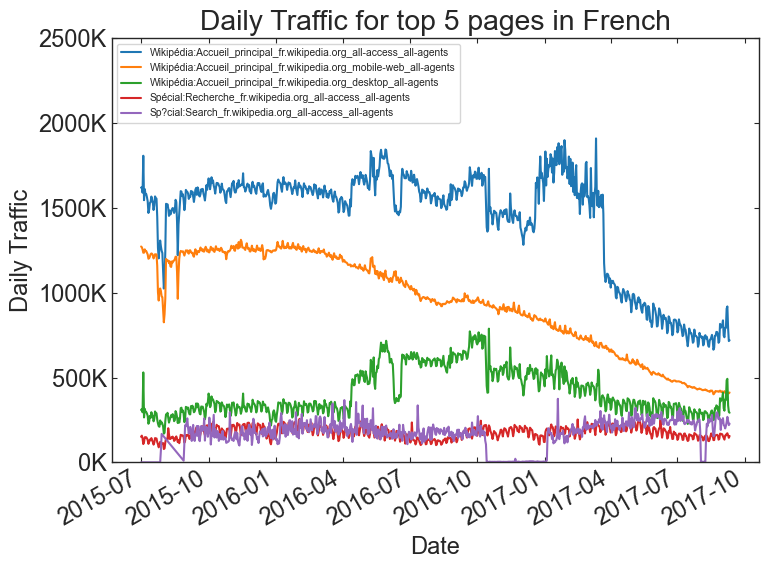

In [8]:
fig, ax = plt.subplots()

# tick format function 
# 'K' stands for thousand (1e3)
ticklabel_func = lambda value, tick_number: "{:.0f}K".format(value/1e3) 

pages_fr_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.set_ylim(0,2.5e6)
ax.legend(loc='upper left', fontsize=7.4)
ax.set_title('Daily Traffic for top 5 pages in French')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_fr.png'));

### Top 5 pages published in Spanish

In [9]:
# extract the data for the Spanish pages
pages_es = train_imputed.loc[train_imputed.Language=='Spanish']
pages_title = pages_es.Page
pages_es = pages_es.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_es.columns = pd.to_datetime(pages_es.columns)

# compute the mean view
pages_es['mean_view'] = pages_es.mean(axis=1)

pages_es = pd.concat([pages_title, pages_es], axis=1)

# find the top 5 popular pages
pages_es_top5 = pages_es.sort_values(by='mean_view', ascending=False)[0:5]

pages_es_top5.set_index('Page', inplace=True)
pages_es_top5['mean_view']

Page
Wikipedia:Portada_es.wikipedia.org_all-access_all-agents    1.193890e+06
Wikipedia:Portada_es.wikipedia.org_mobile-web_all-agents    8.650971e+05
Especial:Buscar_es.wikipedia.org_all-access_all-agents      3.926048e+05
Wikipedia:Portada_es.wikipedia.org_desktop_all-agents       2.824673e+05
Especial:Buscar_es.wikipedia.org_desktop_all-agents         2.685190e+05
Name: mean_view, dtype: float64

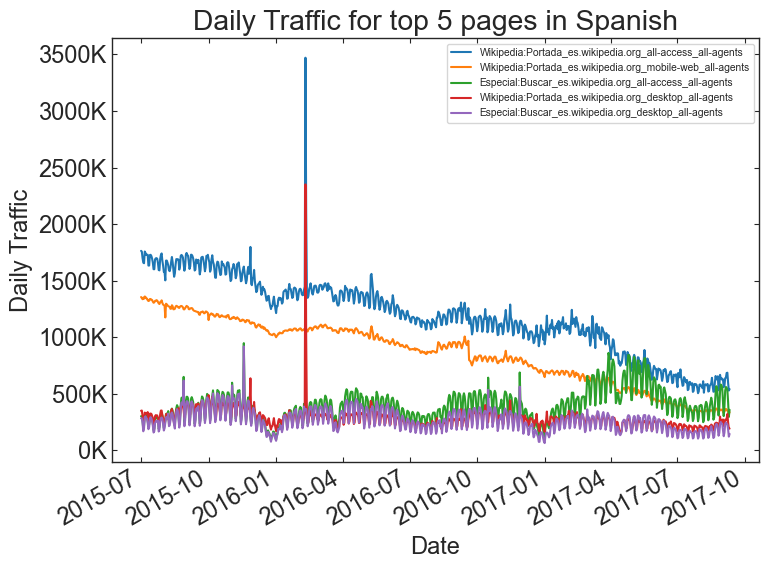

In [10]:
fig, ax = plt.subplots()

# tick format function 
# 'K' stands for thousand (1e3)
ticklabel_func = lambda value, tick_number: "{:.0f}K".format(value/1e3) 

pages_es_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
#ax.set_ylim(0,2.5e6)
ax.legend(loc='upper right', fontsize=7.4)
ax.set_title('Daily Traffic for top 5 pages in Spanish')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_es.png'));

### Top 5 pages published in Russian

In [11]:
# extract the data for the Russian pages
pages_ru = train_imputed.loc[train_imputed.Language=='Russian']
pages_title = pages_ru.Page
pages_ru = pages_ru.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_ru.columns = pd.to_datetime(pages_ru.columns)

# compute the mean view
pages_ru['mean_view'] = pages_ru.mean(axis=1)

pages_ru = pd.concat([pages_title, pages_ru], axis=1)

# find the top 5 popular pages
pages_ru_top5 = pages_ru.sort_values(by='mean_view', ascending=False)[0:5]

pages_ru_top5.set_index('Page', inplace=True)
pages_ru_top5['mean_view']

Page
Заглавная_страница_ru.wikipedia.org_all-access_all-agents    1.621087e+06
Заглавная_страница_ru.wikipedia.org_desktop_all-agents       1.082970e+06
Заглавная_страница_ru.wikipedia.org_mobile-web_all-agents    5.099749e+05
Служебная:Поиск_ru.wikipedia.org_all-access_all-agents       1.801692e+05
Служебная:Поиск_ru.wikipedia.org_desktop_all-agents          1.641143e+05
Name: mean_view, dtype: float64

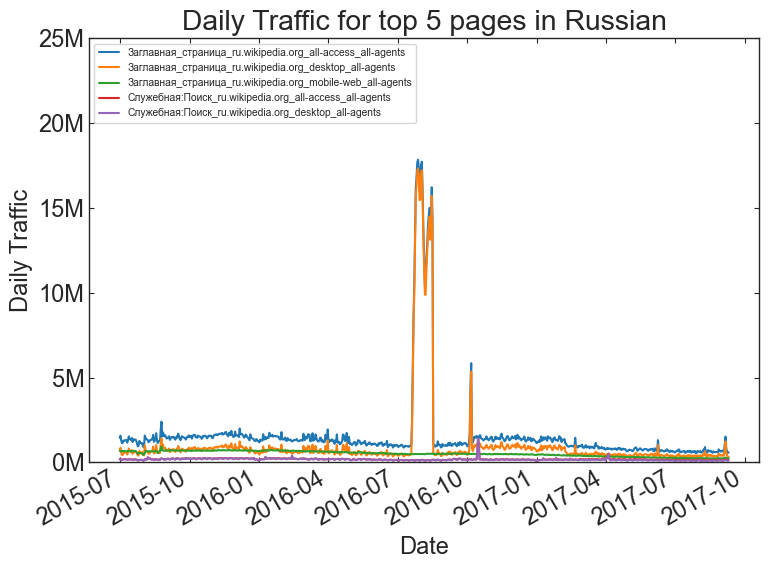

In [12]:
fig, ax = plt.subplots()

# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

pages_ru_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.set_ylim(0,2.5e7)
ax.legend(loc='upper left', fontsize=7.4)
ax.set_title('Daily Traffic for top 5 pages in Russian')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_ru.png'));

### Top 5 pages published in German

In [13]:
# extract the data for the German pages
pages_de = train_imputed.loc[train_imputed.Language=='German']
pages_title = pages_de.Page
pages_de = pages_de.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_de.columns = pd.to_datetime(pages_de.columns)

# compute the mean view
pages_de['mean_view'] = pages_de.mean(axis=1)

pages_de = pd.concat([pages_title, pages_de], axis=1)

# find the top 5 popular pages
pages_de_top5 = pages_de.sort_values(by='mean_view', ascending=False)[0:5]

pages_de_top5.set_index('Page', inplace=True)
pages_de_top5['mean_view']

Page
Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents    2.823571e+06
Wikipedia:Hauptseite_de.wikipedia.org_mobile-web_all-agents    1.774385e+06
Wikipedia:Hauptseite_de.wikipedia.org_desktop_all-agents       7.796793e+05
Spezial:Suche_de.wikipedia.org_all-access_all-agents           3.949703e+05
Spezial:Suche_de.wikipedia.org_desktop_all-agents              3.805297e+05
Name: mean_view, dtype: float64

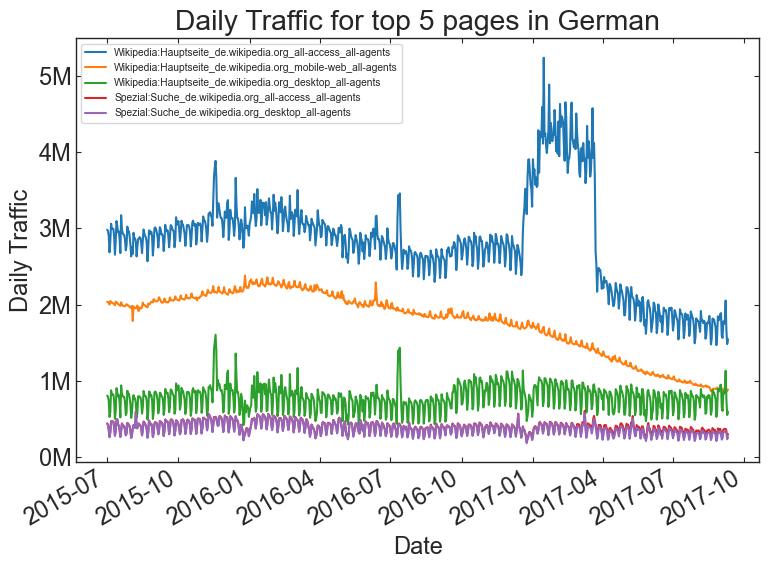

In [14]:
fig, ax = plt.subplots()

# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

pages_de_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
#ax.set_ylim(0,2.5e7)
ax.legend(loc='upper left', fontsize=7.4)
ax.set_title('Daily Traffic for top 5 pages in German')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_de.png'));

### Top 5 pages published in Japanese

In [15]:
# extract the data for the Japanese pages
pages_ja = train_imputed.loc[train_imputed.Language=='Japanese']
pages_title = pages_ja.Page
pages_ja = pages_ja.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_ja.columns = pd.to_datetime(pages_ja.columns)

# compute the mean view
pages_ja['mean_view'] = pages_ja.mean(axis=1)

pages_ja = pd.concat([pages_title, pages_ja], axis=1)

# find the top 5 popular pages
pages_ja_top5 = pages_ja.sort_values(by='mean_view', ascending=False)[0:5]

pages_ja_top5.set_index('Page', inplace=True)
pages_ja_top5['mean_view']

Page
メインページ_ja.wikipedia.org_all-access_all-agents    401846.412204
メインページ_ja.wikipedia.org_desktop_all-agents       248167.875467
特別:検索_ja.wikipedia.org_all-access_all-agents     131630.523039
特別:検索_ja.wikipedia.org_desktop_all-agents        125706.230386
メインページ_ja.wikipedia.org_mobile-web_all-agents    115160.455791
Name: mean_view, dtype: float64

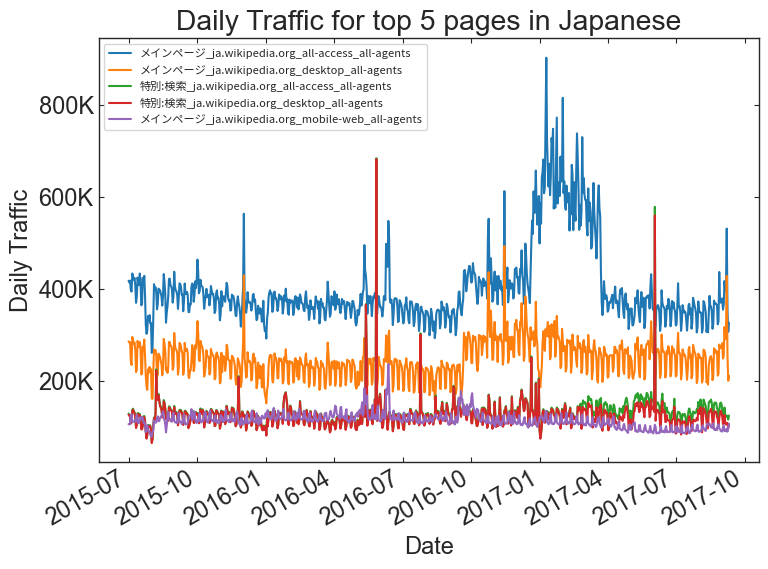

In [16]:
fig, ax = plt.subplots()

# to show the Japanese character
fprop = fm.FontProperties(fname='/Users/astrodoo/Library/Fonts/NotoSansJP-Regular.otf', size=8)

# tick format function 
# 'K' stands for thousand (1e3)
ticklabel_func = lambda value, tick_number: "{:.0f}K".format(value/1e3) 

pages_ja_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
#ax.set_ylim(0,2.5e7)
ax.legend(loc='upper left', prop=fprop)
ax.set_title('Daily Traffic for top 5 pages in Japanese')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_ja.png'));

### Top 5 pages published in Chinese

In [17]:
# extract the data for the Chinese pages
pages_zh = train_imputed.loc[train_imputed.Language=='Chinese']
pages_title = pages_zh.Page
pages_zh = pages_zh.drop(columns=['Page','Language','Agent','Access'])

# convert the format of column names from string to datetime
pages_zh.columns = pd.to_datetime(pages_zh.columns)

# compute the mean view
pages_zh['mean_view'] = pages_zh.mean(axis=1)

pages_zh = pd.concat([pages_title, pages_zh], axis=1)

# find the top 5 popular pages
pages_zh_top5 = pages_zh.sort_values(by='mean_view', ascending=False)[0:5]

pages_zh_top5.set_index('Page', inplace=True)
pages_zh_top5['mean_view']

Page
Wikipedia:首页_zh.wikipedia.org_all-access_all-agents    229397.292653
Wikipedia:首页_zh.wikipedia.org_desktop_all-agents       119405.717310
Wikipedia:首页_zh.wikipedia.org_mobile-web_all-agents     93988.247821
Special:搜索_zh.wikipedia.org_all-access_all-agents       88852.108344
Special:搜索_zh.wikipedia.org_desktop_all-agents          83421.981320
Name: mean_view, dtype: float64

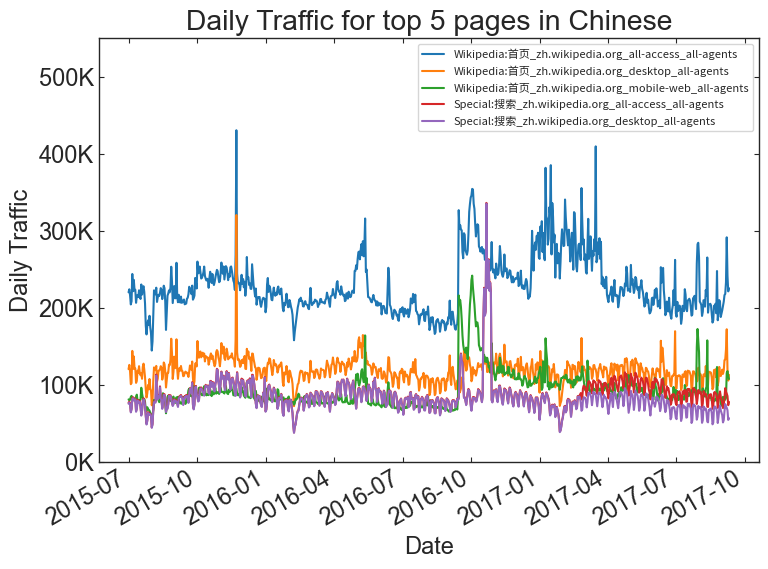

In [18]:
fig, ax = plt.subplots()

# to show the Japanese character
fprop = fm.FontProperties(fname='/Users/astrodoo/Library/Fonts/NotoSansSC-Regular.otf', size=8)

# tick format function 
# 'K' stands for thousand (1e3)
ticklabel_func = lambda value, tick_number: "{:.0f}K".format(value/1e3) 

pages_zh_top5.drop(columns=['mean_view']).T.plot(ax=ax)
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.set_ylim(0,5.5e5)
ax.legend(loc='upper right', prop=fprop)
ax.set_title('Daily Traffic for top 5 pages in Chinese')
ax.set(xlabel='Date', ylabel='Daily Traffic')

fig.tight_layout()
#fig.savefig(os.path.join(figdir,'Daily_Traffic_Top5_zh.png'));

# Conclusion

The data consists of train and key, which contains daily traffic and map of page with id, respectively.
The train data contains 804 columns that consist of page and daily traffic for 803 days. The number of Wikipedia pages is 145k.

We found that there are two kinds of missing data, which are
- data is acutally missing
- the page is not created yet

For the former case, we interpolate the values to fill the missing ones, and for the latter, we simply fill it with zero value.

In Exploratory Data Anaysis(EDA), we found that
- English Wikipedia has the largest pages, which is not surprising.
- Mobile-web access has slightly larger pages than desktop access. 
- there is difference in daily traffic based on language of the data.
    - English wikipedia has the largest daily traffic of all languages.
    - Interestingly, Russian wikipedia has the similar traffic pattern to English Wikipdeia.
- the pattern of the daily traffic is similar between desktop access and mobile-web access with slightly larger traffic in desktop access. Interestingly, it is opposite to the number of articles between two accesses.